In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, RandomHeight, RandomWidth, RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Creating a dataset class object for the data

In [2]:
import os

class_names = sorted(os.listdir("/kaggle/input/stanford-dogs-dataset/images/Images"))

In [3]:
DIR = "/kaggle/input/stanford-dogs-dataset/images/Images"
BATCH_SIZE = 32
IMG_SHAPE = (224, 224)
train_data, test_data = image_dataset_from_directory(DIR, 
                                                     batch_size = BATCH_SIZE,
                                                     image_size = IMG_SHAPE,
                                                     label_mode = 'categorical',
                                                     validation_split = 0.2,
                                                     subset = 'both', seed = 42)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Using 4116 files for validation.


In [4]:
class_names = train_data.class_names

In [5]:
def display_random_image(train_data, class_names):
    for images, labels in train_data.take(1):
        # Select the first image from the batch
        image = images[0].numpy()
        print(class_names[tf.argmax(labels[0])])
        # Display the image using Matplotlib
        plt.imshow(image.astype("uint8"))  # Assuming the image is in uint8 format
        plt.title(f"Class: {labels[0].numpy()}")
        plt.show()

n02091831-Saluki


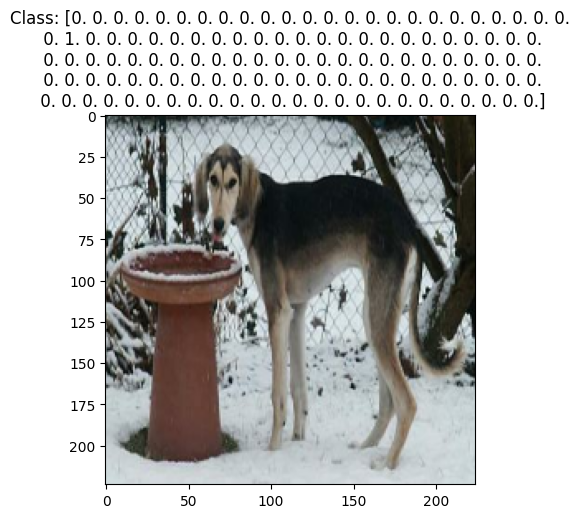

In [6]:
display_random_image(train_data, class_names)

# Creating the baseline model

In [7]:
inputs = tf.keras.layers.Input(shape = IMG_SHAPE + (3, ))
x = Conv2D(256, 5, activation = 'relu')(inputs)
x = Conv2D(256, 5, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 5, activation = 'relu')(x)
x = Conv2D(128, 5, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Conv2D(64, 5, activation = 'relu')(x)
x = Conv2D(64, 5, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(120, activation = 'softmax')(x)

model1 = Model(inputs, outputs)

In [8]:
model1.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(0.01),
               metrics = ['accuracy'])

In [9]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 256)     19456     
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 216, 256)     1638656   
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 108, 256)     0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 104, 104, 128)     819328    
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     409728    
                                                             

In [10]:
history1 = model1.fit(train_data, epochs = 5, validation_data = test_data, validation_steps = (0.5*len(test_data)))

Epoch 1/5
515/515 [==============================] - 948s 2s/step - loss: 223686.6562 - accuracy: 0.0101 - val_loss: 4.7895 - val_accuracy: 0.0106
Epoch 2/5
515/515 [==============================] - 854s 2s/step - loss: 4.7849 - accuracy: 0.0117 - val_loss: 4.7915 - val_accuracy: 0.0106
Epoch 3/5
515/515 [==============================] - 854s 2s/step - loss: 4.7851 - accuracy: 0.0115 - val_loss: 4.7920 - val_accuracy: 0.0106
Epoch 4/5
515/515 [==============================] - 854s 2s/step - loss: 4.7851 - accuracy: 0.0117 - val_loss: 4.7921 - val_accuracy: 0.0106
Epoch 5/5
515/515 [==============================] - 854s 2s/step - loss: 4.7853 - accuracy: 0.0117 - val_loss: 4.7916 - val_accuracy: 0.0106


In [11]:
def plot_history_graph(history_feature_extraction):
  accuracy = history_feature_extraction.history['accuracy']
  val_accuracy = history_feature_extraction.history['val_accuracy']

  loss = history_feature_extraction.history['loss']
  val_loss = history_feature_extraction.history['val_loss']

  epoch = history_feature_extraction.epoch

  figure = plt.figure(figsize = (10, 5))
  plt.plot(epoch, accuracy, label = 'training accuracy')
  plt.plot(epoch, val_accuracy, label = 'testing accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title("accuracy graph")
  plt.legend()

  figure2 = plt.figure(figsize = (10, 5))
  plt.plot(epoch, loss, label = 'training loss')
  plt.plot(epoch, val_loss, label = 'testing  loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title("loss curve")
  plt.legend()

  plt.show()

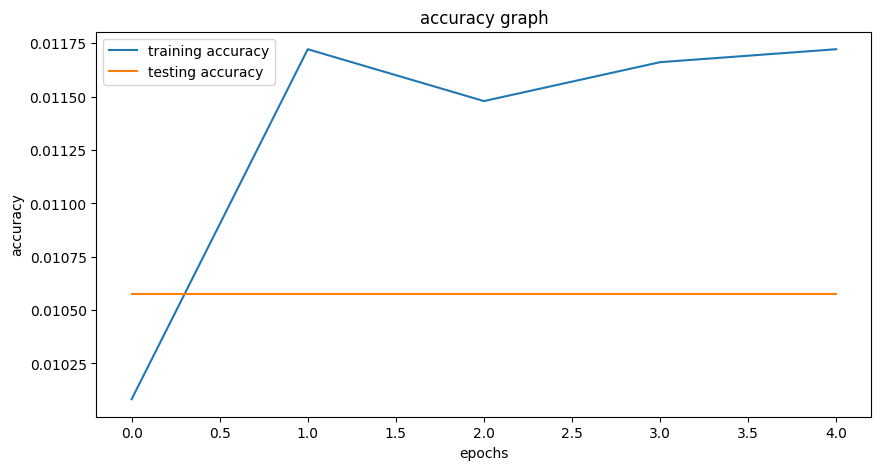

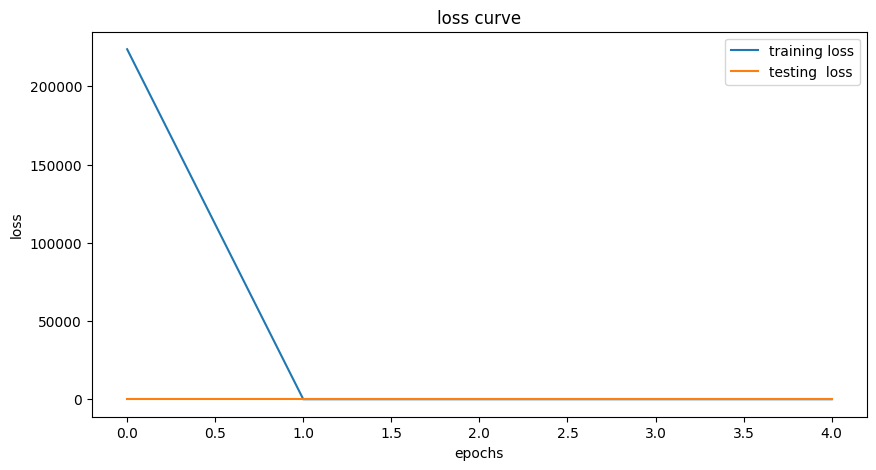

In [12]:
plot_history_graph(history1)

* The loss isn't going down and the accuracy is not improving either, we'll create a new model with data aug and scaling

# Model 2 - Reduce Conv kernel size, introduce data augmentation and global average pooling

**Note** : For some reason the gpu was taking too long to augment the data so we are going to use the image data generator to augment our data

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 0.2, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True,
                            validation_split = 0.2)
train_data_aug = datagen.flow_from_directory(DIR, target_size = IMG_SHAPE, batch_size = BATCH_SIZE, class_mode = 'categorical', subset = 'training')
test_data_aug = datagen.flow_from_directory(DIR, target_size = IMG_SHAPE, batch_size = BATCH_SIZE, class_mode = 'categorical', subset = 'validation')



Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [14]:
inputs = tf.keras.layers.Input(shape = IMG_SHAPE + (3, ))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = Conv2D(256, 3, activation = 'relu')(x)
x = Conv2D(256, 3, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, activation = 'relu')(x)
x = Conv2D(128, 3, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation = 'relu')(x)
x = Conv2D(64, 3, activation = 'relu')(x)
x = MaxPool2D()(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(120, activation = 'softmax')(x)

model2 = Model(inputs, outputs)

In [15]:
model2.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [16]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 256)     7168      
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 256)     590080    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 110, 110, 256)     0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 128)     295040    
                                                           

In [17]:
history2 = model2.fit(train_data_aug, epochs = 5, validation_data = test_data_aug, validation_steps = (0.5 * len(test_data_aug)))

Epoch 1/5
516/516 [==============================] - 639s 1s/step - loss: 4.7868 - accuracy: 0.0101 - val_loss: 4.7839 - val_accuracy: 0.0122
Epoch 2/5
516/516 [==============================] - 586s 1s/step - loss: 4.7826 - accuracy: 0.0114 - val_loss: 4.7795 - val_accuracy: 0.0122
Epoch 3/5
516/516 [==============================] - 583s 1s/step - loss: 4.7812 - accuracy: 0.0122 - val_loss: 4.7797 - val_accuracy: 0.0112
Epoch 4/5
516/516 [==============================] - 582s 1s/step - loss: 4.7808 - accuracy: 0.0121 - val_loss: 4.7802 - val_accuracy: 0.0098
Epoch 5/5
516/516 [==============================] - 576s 1s/step - loss: 4.7804 - accuracy: 0.0119 - val_loss: 4.7793 - val_accuracy: 0.0107


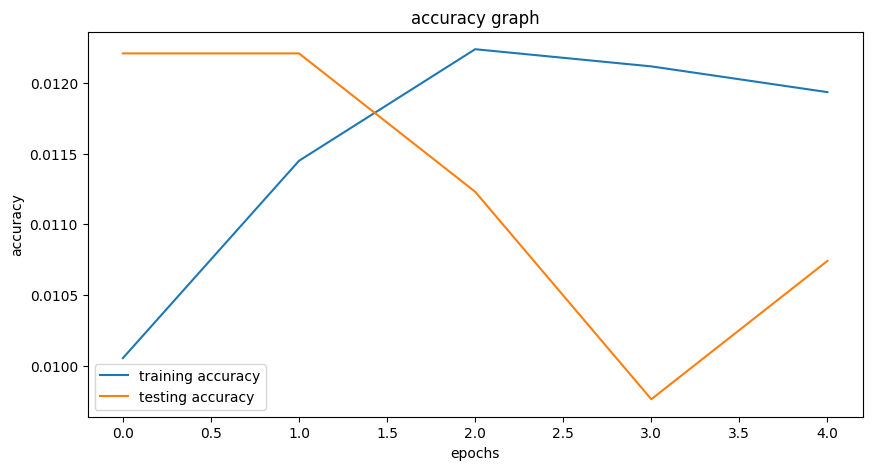

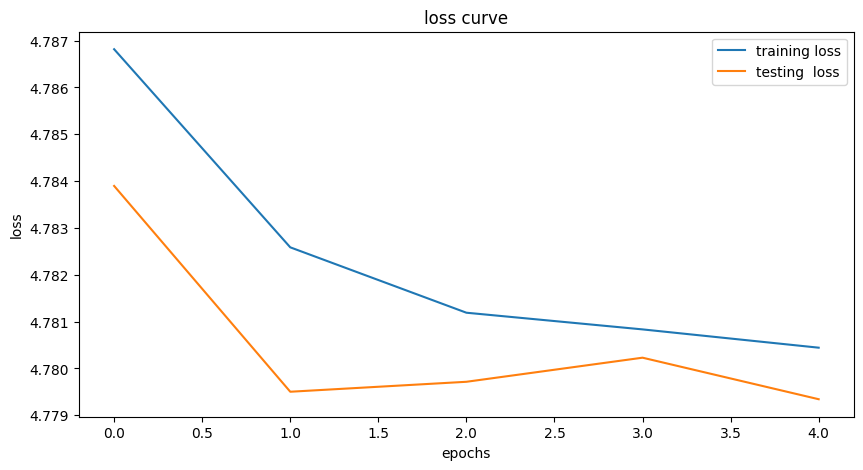

In [18]:
plot_history_graph(history2)

* Model 2 is not performing any better, next try increase the number of layers and decrease per layer convolutions

# Model3 - Increase number of convolution layers, decrease pooling layers

In [19]:
inputs = tf.keras.layers.Input(shape = IMG_SHAPE + (3, ))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = Conv2D(64, 3, activation = 'relu')(x)
x = Conv2D(64, 3, activation = 'relu')(x)
x = Conv2D(64, 3, activation = 'relu')(x)
x = Conv2D(64, 3, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Conv2D(32, 3, activation = 'relu')(x)
x = Conv2D(32, 3, activation = 'relu')(x)
x = Conv2D(32, 3, activation = 'relu')(x)
x = Conv2D(32, 3, activation = 'relu')(x)
x = MaxPool2D()(x)
x = Conv2D(16, 3, activation = 'relu')(x)
x = Conv2D(16, 3, activation = 'relu')(x)
x = Conv2D(16, 3, activation = 'relu')(x)
x = Conv2D(16, 3, activation = 'relu')(x)
x = Flatten()(x)
outputs = Dense(120, activation = 'softmax')(x)

model3 = Model(inputs, outputs)

In [20]:
model3.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 conv2d_14 (Conv2D)          (None, 218, 218, 64)      36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 216, 216, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 108, 108, 64)      0   

In [21]:
history3 = model3.fit(train_data_aug, epochs = 5, validation_data = test_data_aug, validation_steps = (0.5 * len(test_data_aug)))

Epoch 1/5
516/516 [==============================] - 292s 538ms/step - loss: 4.7866 - accuracy: 0.0111 - val_loss: 4.7847 - val_accuracy: 0.0156
Epoch 2/5
516/516 [==============================] - 266s 515ms/step - loss: 4.7838 - accuracy: 0.0122 - val_loss: 4.7808 - val_accuracy: 0.0112
Epoch 3/5
516/516 [==============================] - 266s 514ms/step - loss: 4.7820 - accuracy: 0.0122 - val_loss: 4.7826 - val_accuracy: 0.0122
Epoch 4/5
516/516 [==============================] - 265s 513ms/step - loss: 4.7810 - accuracy: 0.0122 - val_loss: 4.7786 - val_accuracy: 0.0112
Epoch 5/5
516/516 [==============================] - 267s 516ms/step - loss: 4.7805 - accuracy: 0.0122 - val_loss: 4.7765 - val_accuracy: 0.0137


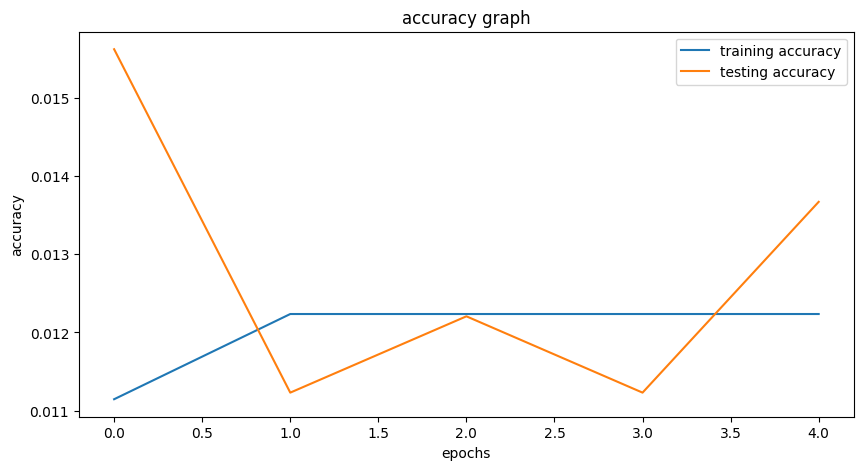

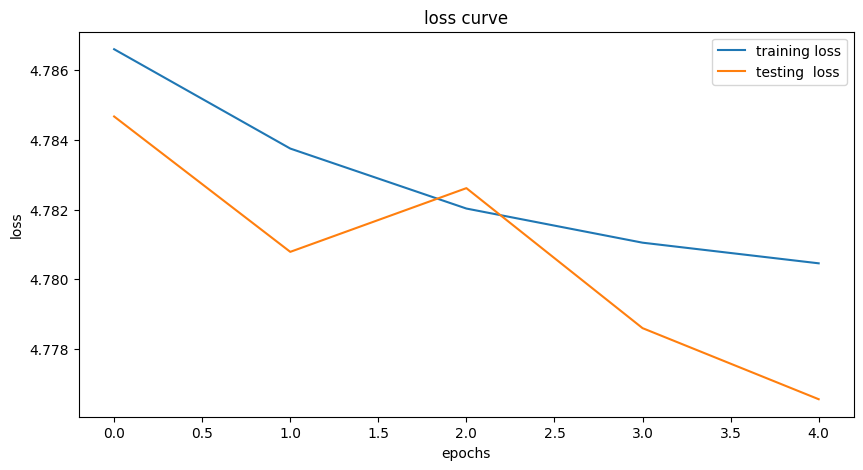

In [22]:
plot_history_graph(history3)

* The model still isn't performing any good, lets try and use transfer learning to drastically increase the accuracy of our model

# Transfer Learning


In [23]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = IMG_SHAPE + (3, ), name = 'InputLayer')

# Base Model Layer
x = base_model(inputs, training = False)

# GAP2D Layer
x = GlobalAveragePooling2D(name = 'GAP2DLayer')(x)

# Output Layer
outputs = Dense(120, activation = 'softmax', name = 'OutputLayer')(x)

# Model creation
model = Model(inputs, outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [24]:
model.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 GAP2DLayer (GlobalAverageP  (None, 1280)              0         
 ooling2D)                                                       
                                                                 
 OutputLayer (Dense)         (None, 120)               153720    
                                                                 
Total params: 6073032 (23.17 MB)
Trainable params: 153720 (600.47 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [25]:
initial_epochs = 3

history_feature_extraction = model.fit(train_data_aug, 
                                       epochs = initial_epochs, 
                                       validation_data = test_data_aug)

Epoch 1/3
516/516 [==============================] - 291s 546ms/step - loss: 1.1988 - accuracy: 0.7464 - val_loss: 0.5860 - val_accuracy: 0.8367
Epoch 2/3
516/516 [==============================] - 285s 553ms/step - loss: 0.4665 - accuracy: 0.8623 - val_loss: 0.5304 - val_accuracy: 0.8416
Epoch 3/3
516/516 [==============================] - 277s 538ms/step - loss: 0.3751 - accuracy: 0.8824 - val_loss: 0.5167 - val_accuracy: 0.8421


In [26]:
model.evaluate(test_data_aug)

128/128 [==============================] - 57s 443ms/step - loss: 0.5122 - accuracy: 0.8453


[0.512248694896698, 0.8452848792076111]

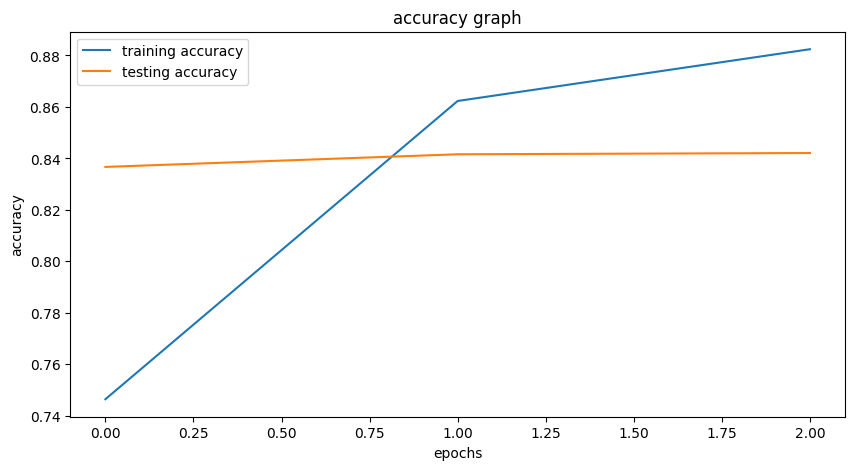

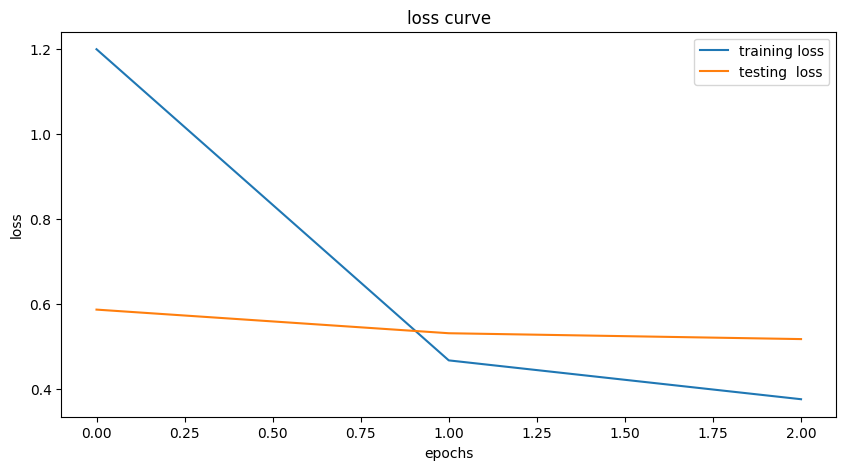

In [27]:
plot_history_graph(history_feature_extraction)

# Trying to fine tune and see if we can squeeze a bit more accuracy

In [28]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

for x in base_model.layers:
    if x.trainable == True:
        print(x.name, x.trainable)
print('total layers -', len(base_model.layers))

block6h_se_reduce True
block6h_se_expand True
block6h_se_excite True
block6h_project_conv True
block6h_project_bn True
block6h_drop True
block6h_add True
top_conv True
top_bn True
top_activation True
total layers - 270


In [29]:
model.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(0.0005), # reducing learning rate to not overfit on current dataset
               metrics = ['accuracy'])
fine_tuning_epochs = initial_epochs + 5

history_fine_tuning = model.fit(train_data_aug, 
                                 epochs = fine_tuning_epochs,
                                 initial_epoch = initial_epochs, 
                                 validation_data = test_data_aug,
                                 validation_steps = (0.5 * len(test_data_aug)))

Epoch 4/8
516/516 [==============================] - 273s 509ms/step - loss: 0.3538 - accuracy: 0.8823 - val_loss: 0.5192 - val_accuracy: 0.8340
Epoch 5/8
516/516 [==============================] - 253s 491ms/step - loss: 0.2827 - accuracy: 0.9031 - val_loss: 0.5591 - val_accuracy: 0.8311
Epoch 6/8
516/516 [==============================] - 253s 490ms/step - loss: 0.2317 - accuracy: 0.9234 - val_loss: 0.6010 - val_accuracy: 0.8320
Epoch 7/8
516/516 [==============================] - 253s 491ms/step - loss: 0.1927 - accuracy: 0.9354 - val_loss: 0.6114 - val_accuracy: 0.8291
Epoch 8/8
516/516 [==============================] - 252s 488ms/step - loss: 0.1647 - accuracy: 0.9432 - val_loss: 0.5716 - val_accuracy: 0.8364


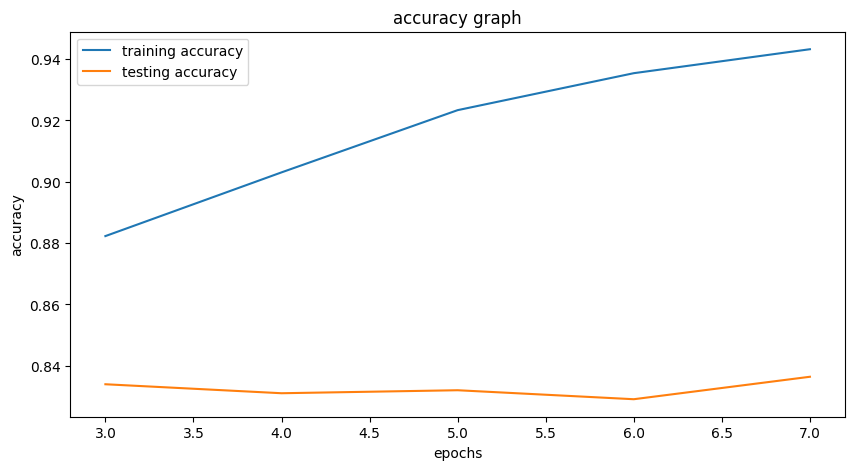

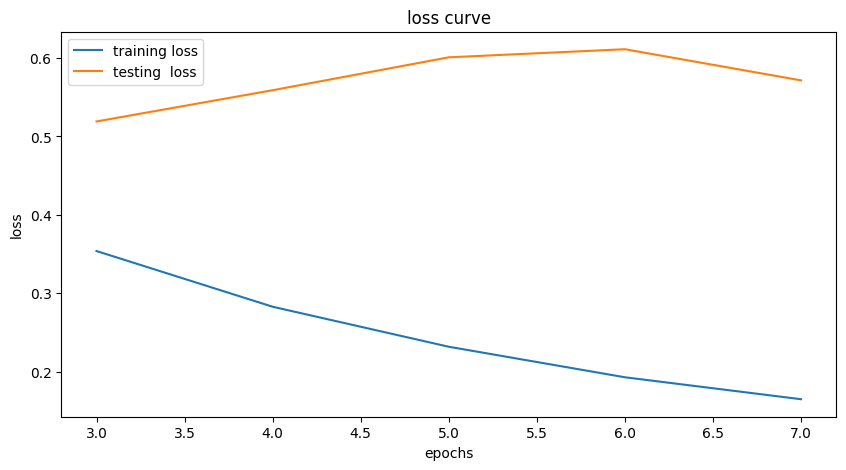

In [30]:
plot_history_graph(history_fine_tuning)

In [31]:
# final accuracy

model.evaluate(test_data_aug)

128/128 [==============================] - 57s 444ms/step - loss: 0.6132 - accuracy: 0.8222


[0.6132187247276306, 0.8222004175186157]